In [0]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
                        input_shape=(150, 150, 3),
                        include_top=False,
                        weights=None
                        )

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable=False
  
# Print the model summary
pre_trained_model.summary()


In [5]:
last_layer = pre_trained_model.get_layer('mixed9_1')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

('last layer output shape: ', (None, 3, 3, 768))


In [0]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [17]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x) 

model.compile(optimizer=RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [10]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2019-06-26 18:37:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.208, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   138MB/s    in 1.0s    

2019-06-26 18:37:55 (138 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2019-06-26 18:37:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.208, 2404:6800:4004:808::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [applicati

In [11]:
train_horse_dir = os.path.join('/tmp/training/horses')
train_human_dir = os.path.join('/tmp/training/humans')
validation_horse_dir = os.path.join('/tmp/validation/horses')
validation_human_dir = os.path.join('/tmp/validation/humans')

500
527
128
128


In [13]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = test_datagen =\
        ImageDataGenerator(rescale = 1./255.,
                           rotation_range = 40,
                           width_shift_range = 0.2,
                           height_shift_range = 0.2,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           horizontal_flip = True)


# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=20,
                                                    target_size=(150, 150),
                                                    class_mode='binary')     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        batch_size=20,
                                                        target_size=(150, 150),
                                                        class_mode='binary')

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [18]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)

callbacks = myCallback()
history = model.fit_generator(
                    train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=51,
                    epochs=200,
                    validation_steps=11,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/200
51/51 - 16s - loss: 0.5826 - acc: 0.6882 - val_loss: 0.2620 - val_acc: 0.8955
Epoch 2/200
51/51 - 13s - loss: 0.4873 - acc: 0.7736 - val_loss: 0.4375 - val_acc: 0.8818
Epoch 3/200
51/51 - 13s - loss: 0.3809 - acc: 0.8441 - val_loss: 0.2345 - val_acc: 0.9455
Epoch 4/200
51/51 - 13s - loss: 0.3673 - acc: 0.8292 - val_loss: 0.4964 - val_acc: 0.9227
Epoch 5/200
51/51 - 13s - loss: 0.3908 - acc: 0.8342 - val_loss: 0.1564 - val_acc: 0.9636
Epoch 6/200
51/51 - 13s - loss: 0.3435 - acc: 0.8570 - val_loss: 0.1459 - val_acc: 0.9682
Epoch 7/200
51/51 - 12s - loss: 0.3068 - acc: 0.8610 - val_loss: 0.6274 - val_acc: 0.9091
Epoch 8/200
51/51 - 12s - loss: 0.3312 - acc: 0.8779 - val_loss: 0.2580 - val_acc: 0.9636
Epoch 9/200
51/51 - 12s - loss: 0.3009 - acc: 0.8709 - val_loss: 0.3616 - val_acc: 0.9273
Epoch 10/200
51/51 - 12s - loss: 0.3051 - acc: 0.8828 - val_loss: 0.2953 - val_acc: 0.9591
Epoch 11/200
51/51 - 12s - loss: 0.3148 - acc: 0.8838 - val_loss: 1.7684 - val_acc: 0.8136
Epoch 12

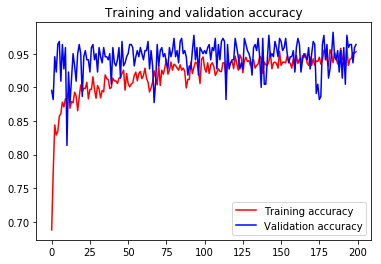

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [0]:
history2 = model.fit_generator(
                    train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=51,
                    epochs=200,
                    validation_steps=11,
                    verbose=2,
                    callbacks=[callbacks])

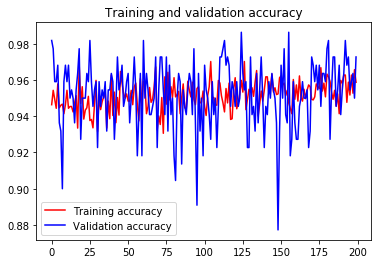

<Figure size 432x288 with 0 Axes>

In [21]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()